# Практическое задание

## Интерполяция байеровского шаблона (demosaicing)

### О задании

В этом задании вам предстоит познакомится с простейшими инструментами считывания и обработки изображений в python, и с помощью них реализовать и протестировать 2 метода интерполяции байеровского шаблона. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. 
Вам понадобится работать со следущими пакетами:

* [`numpy`](https://docs.scipy.org/doc/numpy/reference/index.html) - библиотека для работы с многомерными масивами и матрицами, содержащая большое кол-во высокоуровневых математических функций для операций с этими масивами.  


* [`skimage`](http://scikit-image.org/) - библиотека, содержащие большую коллекцию алгоритмов для обработки изображений;

* [`scipy`](https://www.scipy.org/) - библиотека, содержащая большой набор инструментов для математических и инженерных вычислений. Основная структура данных numpy массив.

* [`matplotlib`](https://matplotlib.org/) - библиотека для визуализации различных графиков, диаграмм, изображений и много другого.

### Общая информация

Фильтр Байера - это матрица цветных фильтров для фотосенсора фотоаппарта. Каждая ячейка матрицы представляет собой фильтр одного из цветов R, G или B. В классическом фильтре Байера применяются светофильтры трёх основных цветов в следующем порядке: <img src="bayer_pat.png" width="50">
Матрица является устройством, воспринимающим спроецированное на него изображение. Вследствие использования фильтров каждый фотоприемник воспринимает лишь 1/3 цветовой информации участка изображения, а 2/3 отсекается фильтром. Недостающие компоненты цвета рассчитываются процессором камеры на основании данных из соседних ячеек в результате интерполяции (demosaicing).
<img src="bayer.jpg" width="500">

Вам необходимо будет научиться востанавливать "полноцветное" изображение по байеровскому шаблону.

Вместе с заданием вам был выдан архив `data.zip`. В нем содержатся следущие данные:
* `raw/` - директория с  различными одноканальными изображениями, полученными с помощью фильтра Байера. Фильтр Байера который применялся, соответствует последовательности каналов(GRGB), показанной выше. В каждом пикселе изображения записан отклик фильтра соответсвующего цвета;
* `gt/` - директория с *ground truth* изображениями, каждому raw-изображению из предыдущей директории существует изображение из этой директории(с тем же именем) с истинными значениями RGB-канналов в каждом пикселе;
* `debug/` - изображения для самопроверки работы алгоритмов.

Выполненный нотбук сдается вместе с папкой `results`, где должны лежать результаты работы алгоритмов. Ниже будет описано подробнее. Все необходимо заархивировать в один zip файл.

### Практическая часть

In [2]:
import skimage.io
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
GT_DIR = 'data/gt/'
RAW_DIR = 'data/raw/'

**1. (0.5 балла)**

Считайте raw и ground truth изображения `IMG0001.bmp`, выведите в какой тип данных они считались(список, массив, ...?), какой тип данных у пикселей изображения(float, int, ...?), размеры изображений.  Подумайте на тем как хранятся изображения в памяти.

Вам могут понадобиться:
* `skimage.io.imread(..)`

**Hint**: в jupyter-notebook если после ввода названия функции нажать сочетание клавиш `shift+tab` , выведется докстринг этой функции.

In [4]:
gt_image = skimage.io.imread(GT_DIR + 'IMG0001.bmp')
raw_image = skimage.io.imread(RAW_DIR + 'IMG0001.bmp')

print("Тип считанного изображения:", type(gt_image), type(raw_image))
print('Типы элементов матриц:', type(gt_image[0,0,0]), type(raw_image[0,0]))
print("Размеры:", gt_image.shape, raw_image.shape)

Тип считанного изображения: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Типы элементов матриц: <class 'numpy.uint8'> <class 'numpy.uint8'>
Размеры: (512, 768, 3) (512, 768)


Теперь давайте посмотрим на считанные изображения. Для этого воспользуемся:
* `matplotlib.pyplot.subplots(...)` для создания фигуры, заданного размера, с нужным нам количеством окон
* `matplotlib.axes.Axes.imshow(...)` методом объекта `matplotlib.axes.Axes` для вывода изображения

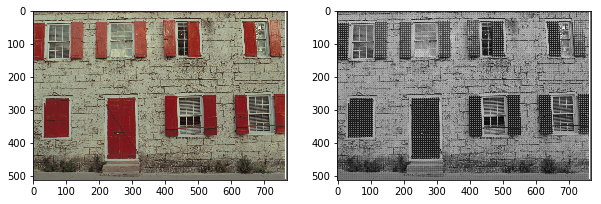

In [6]:
figure, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(gt_image)
axs[1].imshow(raw_image, cmap='gray')
plt.show()

**2. (0.5 балла)**

Перейдем непосредственного к интерепполяции байеровского шаблона.
Напишите вспомогательную функцию, которая для заданного размера raw-изображения создает маски для красных, зеленых и синих каналов байровского шаблона.

Вам могут понадобиться:
* `numpy.tile(...)`

In [65]:
def get_bayer_pattern_masks(h, w):
    """
    Get 3 masks for red, green, blue channels of bayer pattern size (h, w)

    :param h: int, height of bayer pattern
    :param w: int, width of bayer pattern
    :return: [numpy.ndarray((h, w)), numpy.ndarray((h, w)), numpy.ndarray((h, w))],
    list of 3 mask, size (h, w) for red, green, blue channels respectively
    """
    
    return np.tile([[0, 1], [0, 0]], (h//2 + 1, w//2 + 1))[:h, :w], np.tile([[1,0], [0,1]], (h//2 + 1, w//2 +1))[:h, :w], np.tile([[0, 0], [1, 0]], (h//2 + 1, w//2 + 1))[:h, :w]

Проверьте правильность работы  функции с помощью простейшего теста.

In [8]:
# small test for self-examination
r, g, b = get_bayer_pattern_masks(3, 3) 
assert (r == np.array([
    [0, 1, 0], 
    [0, 0, 0], 
    [0, 1, 0]]
)).all()
assert (g == np.array([
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]]
)).all()
assert (b == np.array([
    [0, 0, 0], 
    [1, 0, 1], 
    [0, 0, 0]]
)).all()

**3. (0.5 балла)**

Посмотрим, что на самом деле хранится в raw-изображениях. Напишите функцию, которая создает цветное изображение из raw-изображения следущим образом: в каждый цветовой канал поместите только известные пиксели из raw-изображения, пиксели, в которых данный цвет неизвестен, поставьте 0. Сохраните данное изображение в файл `results/colored_raw_image.bmp` и посмотрите что получилось.

Вам может пригодиться:
* `np.where(...)`
* `skimage.io.imsave(...)`

In [9]:
def get_colored_raw_image(raw_image):
    """
    Create colored raw image.
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), colored raw image
    """
    
    r, g, b = get_bayer_pattern_masks(raw_image.shape[0], raw_image.shape[1])
    
    return np.array((r * raw_image, g * raw_image, b * raw_image), dtype=np.uint8).T.swapaxes(0,1)

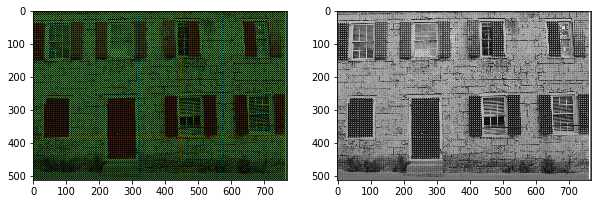

In [10]:
colored_raw_image = get_colored_raw_image(raw_image)

os.makedirs('results/', exist_ok=True)

# your code here
skimage.io.imsave('results/colored_raw_image.bmp', colored_raw_image)
figure, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(colored_raw_image)
axs[1].imshow(raw_image, cmap='gray')
plt.show()

**4. (3 балла)**

Напишите алгоритм билинейной интерполяции байеровского шаблона. В этом алгоритме **неизвестные** значения цветовых компонент вычисляются следущим образом:
* рассматривается окно 3x3 с центром в данном пикселе
* значение цветовой компоненты(r, g, или b) в данном пикселе вычисляется как среднее **заданных** значений данной цветовой компоненты пикселей в этом окне

Например, если, мы хотим интерполировать значение зеленой компоненты цвета в пикселе отмеченном '$+$' на рисунке, нам необходимо усреднить значение 4-х зеленых конпонент в 3x3 окрестности, отмеченных '$\cdot$' 

<img src="example.png" width="130">

В данном задание разрешается обходить матрицу и попиксельно вычислять цветовые компоненты. На будущих занятих вы познакомитесь с понятием "cвертка", и узнаете как на питоне можно было бы избежать обхода матрицы.

Вам может пригодиться:
* `numpy.stack(...)`
* `numpy.rint(...)`

**Замечания:** 
* Поведение на границе, где окно 3x3 неполное, выберите на свое усмотрение, при подсчете метрик оно учитываться не будет.
* Выполнение алгоритма на одном изображении не должно занимать более 20 секунд.
* Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [11]:
def bilinear_interpolation(raw_image):
    """
    Perform bilinear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    h, w = raw_image.shape[0], raw_image.shape[1]
    r, g, b = get_bayer_pattern_masks(h, w)
    n_r, n_g, n_b = np.ones((h, w)) - r, np.ones((h, w)) - g, np.ones((h, w)) - b
    tmp_r, tmp_g, tmp_b = (r * raw_image).astype(np.float64), (g * raw_image).astype(np.float64), (b * raw_image).astype(np.float64)
    image = get_colored_raw_image(raw_image).astype(np.float64)
    
    # your code here
    for i in range(h):
        for j in range(w):
            if n_r[i,j] == 1:
                num = np.sum(r[i -1 : i+2, j - 1: j+2])
                sum = np.sum(tmp_r[i - 1: i+2, j-1:j+2])
                image[i, j, 0] = sum / num
            if n_g[i,j] == 1:
                num = np.sum(g[i -1 : i+2, j - 1: j+2])
                sum = np.sum(tmp_g[i - 1: i+2, j-1:j+2])
                image[i, j, 1] = sum / num
            if n_b[i,j] == 1:
                num = np.sum(b[i -1 : i+2, j - 1: j+2])
                sum = np.sum(tmp_b[i - 1: i+2, j-1:j+2])
                image[i, j, 2] = sum / num

    return np.rint(image).astype(np.uint8)

Проверьте правильность работы функции с помощью простейшего теста. 

In [12]:
%%time
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_bilinear.bmp')
diff = np.abs(bilinear_interpolation(raw_image) - image_true)[1:-1, 1:-1].sum()
assert diff == 0
print(diff)


/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


0
CPU times: user 6.72 s, sys: 49.2 ms, total: 6.77 s
Wall time: 6.84 s


Вычислите билинейную интерполяцию байеровского шаблона для всех изображений из директории `raw/` и сохраните в директорию `results/bilinear/`. Посмотрите на результаты интерполяции, сделайте выводы о плюсах и минусах этого алгоритма.

/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


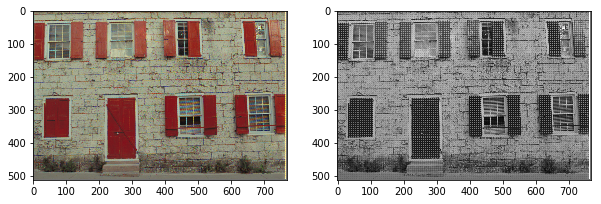

CPU times: user 7.16 s, sys: 43.3 ms, total: 7.2 s
Wall time: 7.02 s


In [13]:
%%time
OUTPUT_DIR = 'results/bilinear'
os.makedirs(OUTPUT_DIR, exist_ok=True)
colored_image = bilinear_interpolation(raw_image)
skimage.io.imsave('results/bilinear/IMG0001.bmp', colored_image)
figure, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(colored_image)
axs[1].imshow(raw_image, cmap='gray')
plt.show()

In [14]:
from tqdm import tqdm_notebook

In [15]:
%%time
for file in tqdm_notebook(os.listdir("data/raw")):
    raw_image = skimage.io.imread('data/raw/{}'.format(file))
    colored_image = bilinear_interpolation(raw_image)
    skimage.io.imsave('results/bilinear/{}'.format(file), colored_image)

/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/Users/ya-philya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars



CPU times: user 2min 46s, sys: 1.12 s, total: 2min 47s
Wall time: 2min 46s


**Выводы:** в принципе работает неплохо и быстро, но наблюдаются артефакты на границах объектов и небольших темных облачтях, особенно хорошо видно на окнах в 1 картинке.

**5. (1 балл)**

Для численной оценки работы алгоритма билинейной интерполяции реализуйте следущие метрики качества:

* Mean squared error $mse(pred\_image, gt\_image) = \frac{1}{3 * h * w} \sum_{i=1}^{h} \sum_{j=1}^{w} \sum_{c=1}^{3} (gt\_image[i, j, c] - pred\_image[i,j,c])^2$ 

* Peak signal-to-noise ratio $psnr(pred\_image, gt\_image) = 10 \log_{10}{(\frac{max(gt\_image)^2}{mse(pred\_image, gt\_image)} )}$

где $gt\_image$ - истинное изображение, $pred\_image$ - предсказанное.

Вычислите среднее значение этих метрик для всего датасета. При подсчете метрик не учитывайте, границу изображения, длиной в 2 пикселя.

Вам может понадобиться:
* `numpy.ndarray.mean(...)`
* `numpy.ndarray.max(...)`
* `numpy.log10(...)`

**Замечание:** Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа, рекомендуется в самом начале вычислений преобразовать изображение в тип `float64`.

In [16]:
def mse_score(pred_image, gt_image):
    """
    Compute mean squared error
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """

    pred_image = pred_image.astype(np.float64)
    gt_image = gt_image.astype(np.float64)
    

    return np.mean((gt_image[2:-2, 2:-2] - pred_image[2:-2,2:-2]) ** 2)


def psnr_score(pred_image, gt_image):
    """
    Compute peak signal-to-noise ratio
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """
    pred_image = pred_image.astype(np.float64)
    gt_image = gt_image.astype(np.float64)
    
    # your code here

    return 10 * np.log10((np.max(gt_image[2:-2,2:-2]) ** 2) / mse_score(pred_image, gt_image))

In [17]:
GT_DIR = 'data/gt/'
OUTPUT_DIR = 'results/bilinear/'
gt_col = skimage.io.imread_collection([GT_DIR + file for file in os.listdir(GT_DIR)])
bil_col = skimage.io.imread_collection([OUTPUT_DIR + file for file in os.listdir(OUTPUT_DIR)])
mse, psnr = [], []
for gt, bil in zip(gt_col, bil_col):
    mse.append(mse_score(bil, gt))
    psnr.append(psnr_score(bil, gt))
np.mean(mse), np.mean(psnr)

(71.73142507117075, 30.5931703660749)

**6. (3.5 балла)**

Теперь реализуем более сложную версию линейной интерполяции баеровского шаблона. Прочитайте статью, выданную вам совместно с ноутбуком, и реализуйте предложенный в ней алгоритм. Вычислите интерполяцию для всех изображений и сохраните в директорию `results/improved/`. Посчитайте средние значения метрик качества. 

**Замечания по поводу алгоритма:**
* в работе указанные фильтры неотнормированны к единице(сумма коэффициентов не равняется 1), чтобы сохранить масштаб значений, коэффициенты необходимо отнормировать на сумму значений в данном фильтре;
* в результате указанных в работе фильтров могут получаться значения большие 255 и меньшие 0, вам необходимо отрезать слишком большие и слишком маленькие значения по крайним значениям(`numpy.clip`);
* веса фильтров были выписаны в массивы за вас для избежания лишних ошибок.

**Замечание:** Как никогда будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [18]:
weigths_0 = (1 / 8) * np.array([
    [ 0,  0, 1/2,  0,  0],
    [ 0, -1,   0, -1,  0],
    [-1,  4,   5,  4, -1],
    [ 0, -1,   0, -1,  0],
    [ 0,  0, 1/2,  0,  0]
])

weigths_1 = (1 / 8) * np.array([
    [  0,  0,  -1,  0,   0],
    [  0, -1,   4, -1,   0],
    [1/2,  0,   5,  0, 1/2],
    [  0, -1,   4, -1,   0],
    [  0,  0,  -1,  0,   0]
])

weigths_2 = (1 / 8) * np.array([
    [   0,  0, -3/2,  0,    0],
    [   0,  2,    0,  2,    0],
    [-3/2,  0,    6,  0, -3/2],
    [   0,  2,    0,  2,    0],
    [   0,  0, -3/2,  0,    0]
])

weigths_3 = (1 / 8) * np.array([
    [ 0,  0, -1,  0,  0],
    [ 0,  0,  2,  0,  0],
    [-1,  2,  4,  2, -1],
    [ 0,  0,  2,  0,  0],
    [ 0,  0, -1,  0,  0]
])

In [66]:
def improved_linear_interpolation(raw_image):
    """
    Improved linear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    h, w = raw_image.shape
    
    image = np.zeros((h, w, 3), np.float64)
    
    tmp_raw = np.zeros((h + 4, w + 4))
    tmp_raw[2:-2, 2:-2] = raw_image
    tmp_raw = tmp_raw.astype(np.float64)
    
    raw_image = raw_image.astype(np.float64)
    
    r, g, b = get_bayer_pattern_masks(h, w)
    for i in range(2, h - 2):
        for j in range(2, w - 2):
            filtered_part = raw_image[i - 2:i + 3, j - 2:j + 3]
            
            if r[i, j] == 1:
                image[i, j, 0] = raw_image[i, j]
                image[i, j, 1] = np.sum(weigths_3 * filtered_part)
                image[i, j, 2] = np.sum(weigths_2 * filtered_part)
                continue
            if b[i, j] == 1:
                image[i, j, 0] = np.sum(weigths_2 * filtered_part)
                image[i, j, 1] = np.sum(weigths_3 * filtered_part)
                image[i, j, 2] = raw_image[i, j]
                continue
            if g[i, j] == 1:
                image[i, j, 1] = raw_image[i, j]
                if r[i - 1, j] == 1 and r[i + 1, j] == 1:
                    image[i, j, 0] = np.sum(weigths_1 * filtered_part)
                    image[i, j, 2] = np.sum(weigths_0 * filtered_part)
                    continue
                if r[i, j - 1] == 1 and r[i, j + 1] == 1:
                    image[i, j, 2] = np.sum(weigths_1 * filtered_part)
                    image[i, j, 0] = np.sum(weigths_0 * filtered_part)
                    continue
                

    return np.rint(np.clip(image, 0, 255)).astype(np.uint8)

Проверьте правильность работы функции с помощью прmостейшего теста. 

In [67]:
%%time
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_improved.bmp')
diff = np.abs(improved_linear_interpolation(raw_image) - image_true)[2:-2, 2:-2].sum()
print(diff)
assert diff == 0

0
CPU times: user 5.39 s, sys: 52.6 ms, total: 5.44 s
Wall time: 5.56 s


In [68]:
r, g, b = get_bayer_pattern_masks(raw_image.shape[0], raw_image.shape[1])
improved_image = improved_linear_interpolation(raw_image)
x, y, z = np.nonzero((improved_image - image_true)[2:-2, 2:-2])

In [69]:
image_true[2:-2,2:-2,0][x, y]


array([], dtype=uint8)

In [70]:
improved_image[2:-2,2:-2,0][x, y]

array([], dtype=uint8)

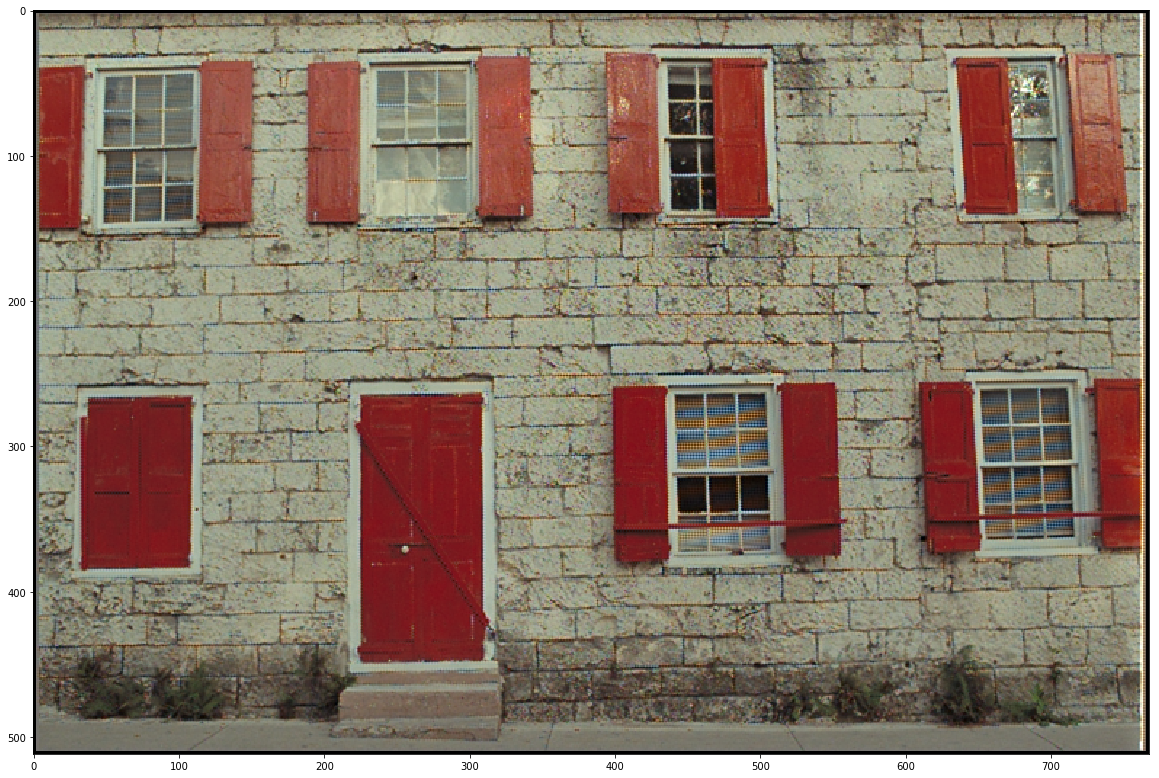

In [71]:
plt.figure(figsize=(20, 20))
plt.imshow(improved_linear_interpolation(raw_image))
plt.show()

In [73]:
%%time
OUTPUT_DIR2 = 'results/improved/'
os.makedirs(OUTPUT_DIR2)

# your code here

for file in tqdm_notebook(os.listdir("data/raw")):
    raw_image = skimage.io.imread('data/raw/{}'.format(file))
    colored_image = improved_linear_interpolation(raw_image)
    skimage.io.imsave(OUTPUT_DIR2 + file, colored_image)


CPU times: user 2min 4s, sys: 1.25 s, total: 2min 5s
Wall time: 2min 9s


**7. (1 балл)**

Проведите сравненение двух алгоритмов. Сравните два алгоритма по метрикам качества. А также выберите сложные моменты("окна" изображениях) для интерполяции и визуализируйте эти "окна". Сравнивайте работу первого алгоритма, второго алгоритма и ground truth. Найдите 3-4 таких "окна". Сделайте выводы.

In [74]:
# your code here
GT_DIR = 'data/gt/'
gt_col = skimage.io.imread_collection([GT_DIR + file for file in os.listdir(GT_DIR)])
bil_col = skimage.io.imread_collection([OUTPUT_DIR2 + file for file in os.listdir(OUTPUT_DIR2)])
mse, psnr = [], []
for gt, bil in zip(gt_col, bil_col):
    mse.append(mse_score(bil, gt))
    psnr.append(psnr_score(bil, gt))
np.mean(mse), np.mean(psnr)

(36.31549015204087, 33.321063624503545)

**Выводы: **

In [75]:
GT_DIR = 'data/gt/'
gt_col = skimage.io.imread_collection([GT_DIR + file for file in os.listdir(GT_DIR)])
bil_col = skimage.io.imread_collection([OUTPUT_DIR2 + file for file in os.listdir(OUTPUT_DIR2)])
mse, psnr = [], []
for gt, bil in zip(gt_col, bil_col):
    mse.append(mse_score(bil, gt))
    psnr.append(psnr_score(bil, gt))
print ("Improved mse {}".format(np.mean(mse)), "Improved psnr {}".format(np.mean(psnr)))

Improved mse 36.31549015204087 Improved psnr 33.321063624503545


In [76]:
GT_DIR = 'data/gt/'
OUTPUT_DIR = 'results/bilinear/'
gt_col = skimage.io.imread_collection([GT_DIR + file for file in os.listdir(GT_DIR)])
bil_col = skimage.io.imread_collection([OUTPUT_DIR + file for file in os.listdir(OUTPUT_DIR)])
mse, psnr = [], []
for gt, bil in zip(gt_col, bil_col):
    mse.append(mse_score(bil, gt))
    psnr.append(psnr_score(bil, gt))
print("Standart mse {}".format(np.mean(mse)), "Standert psnr {}".format(np.mean(psnr)))

Standart mse 71.73142507117075 Standert psnr 30.5931703660749


Как видим mse сильно лучше у улучшенного метода, psnr чуть хуже у улучшенного метода.

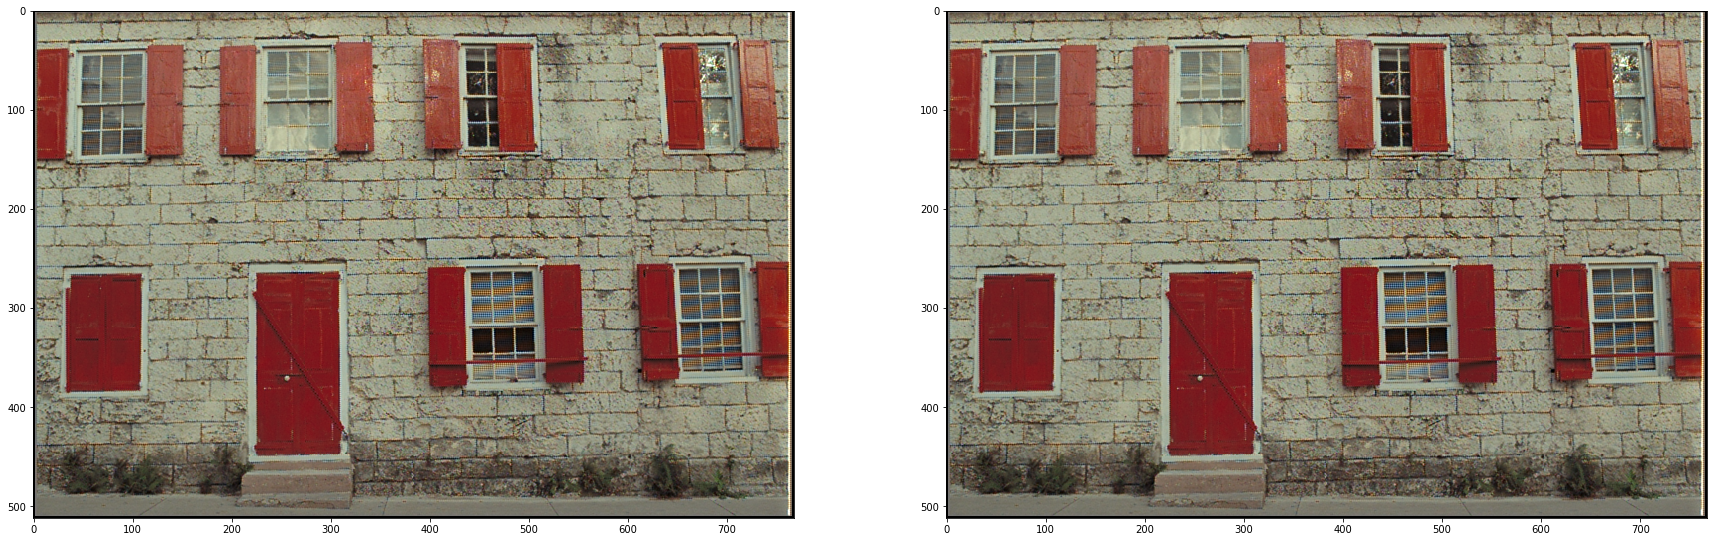

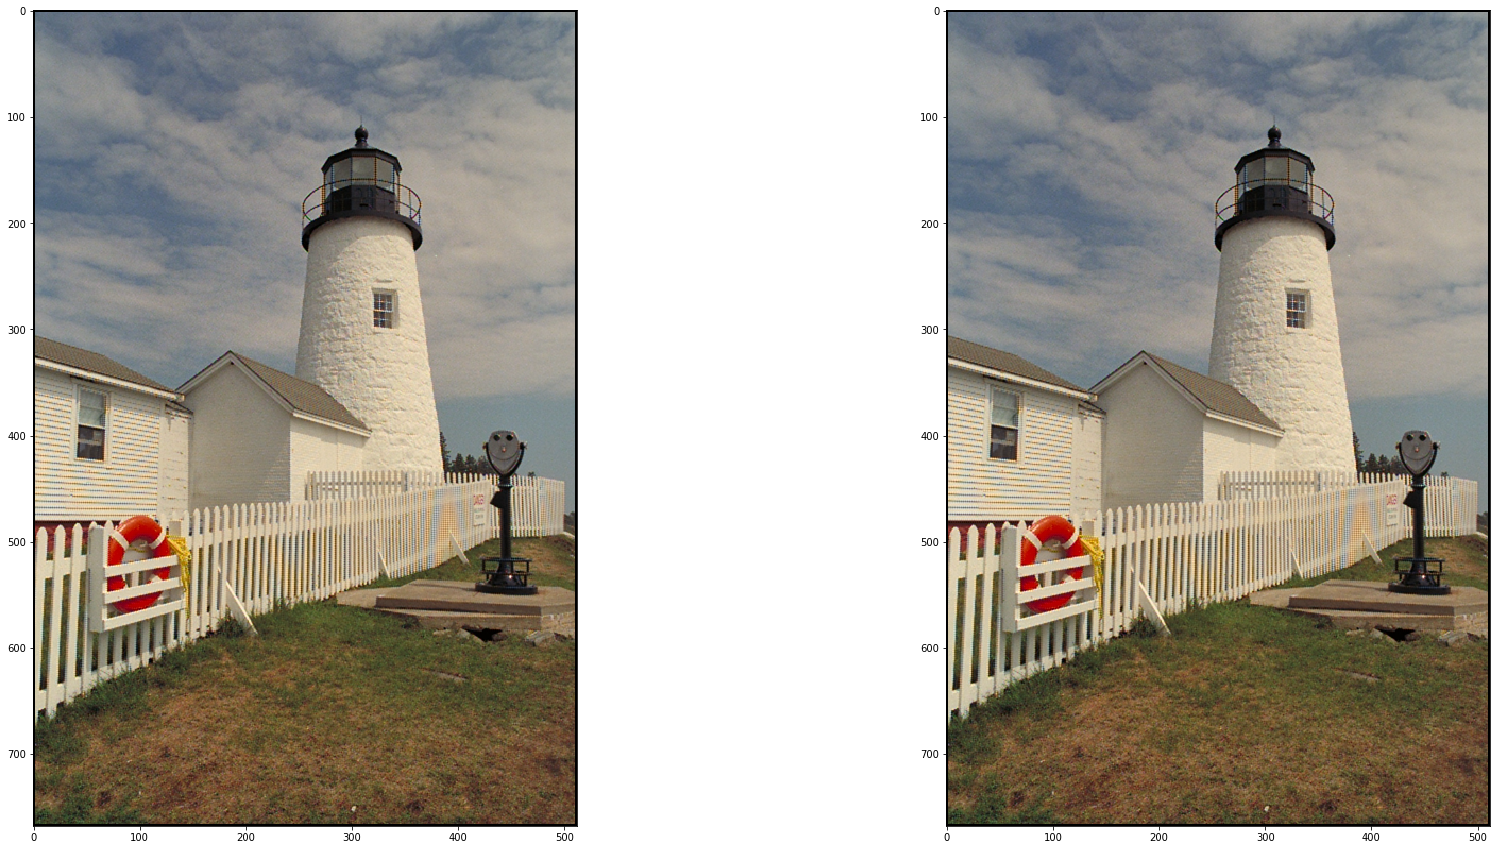

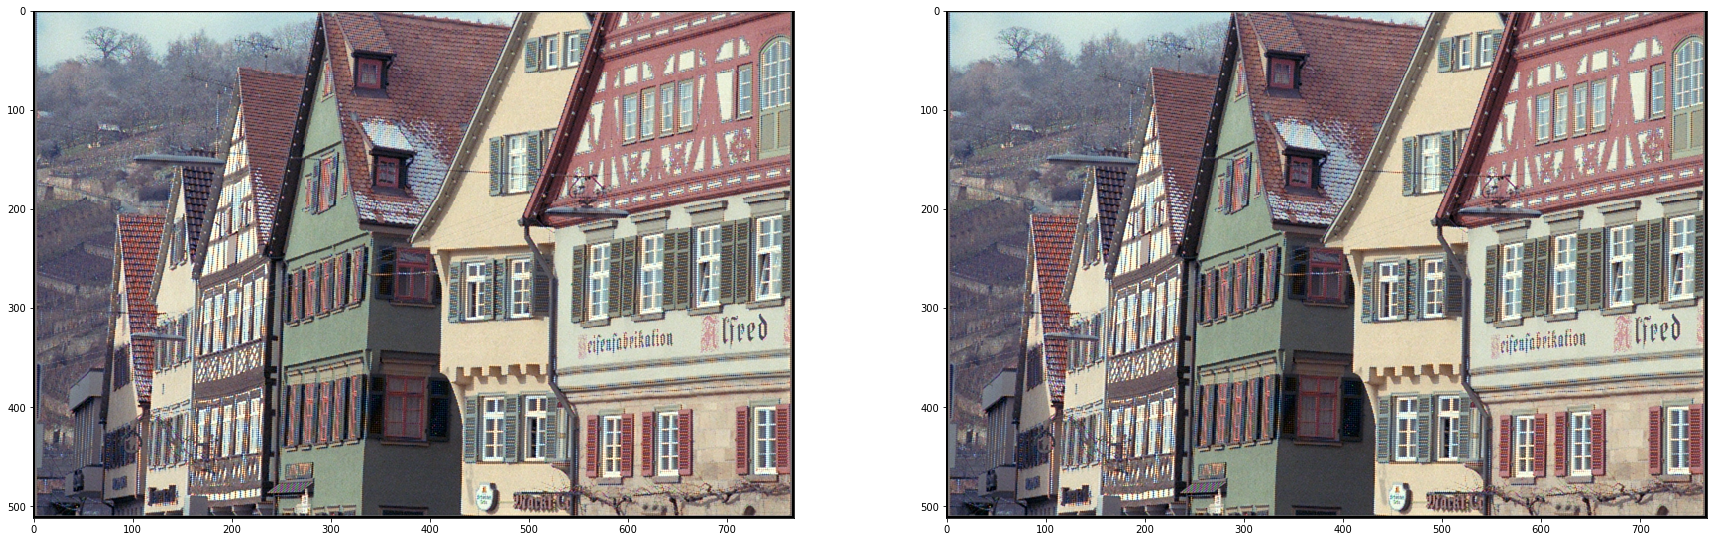

In [80]:
bil_col = skimage.io.imread_collection([OUTPUT_DIR + file for file in os.listdir(OUTPUT_DIR)])
impr = bil_col = skimage.io.imread_collection([OUTPUT_DIR2 + file for file in os.listdir(OUTPUT_DIR2)])
images = [13, 17, 22]
for i in images:
    figure, axs = plt.subplots(1, 2, figsize=(30, 15))

    axs[0].imshow(bil_col[i])
    axs[1].imshow(impr[i])
    plt.show()

Посмотрим более детально

In [81]:
gt_col = skimage.io.imread_collection([GT_DIR + file for file in os.listdir(GT_DIR)])


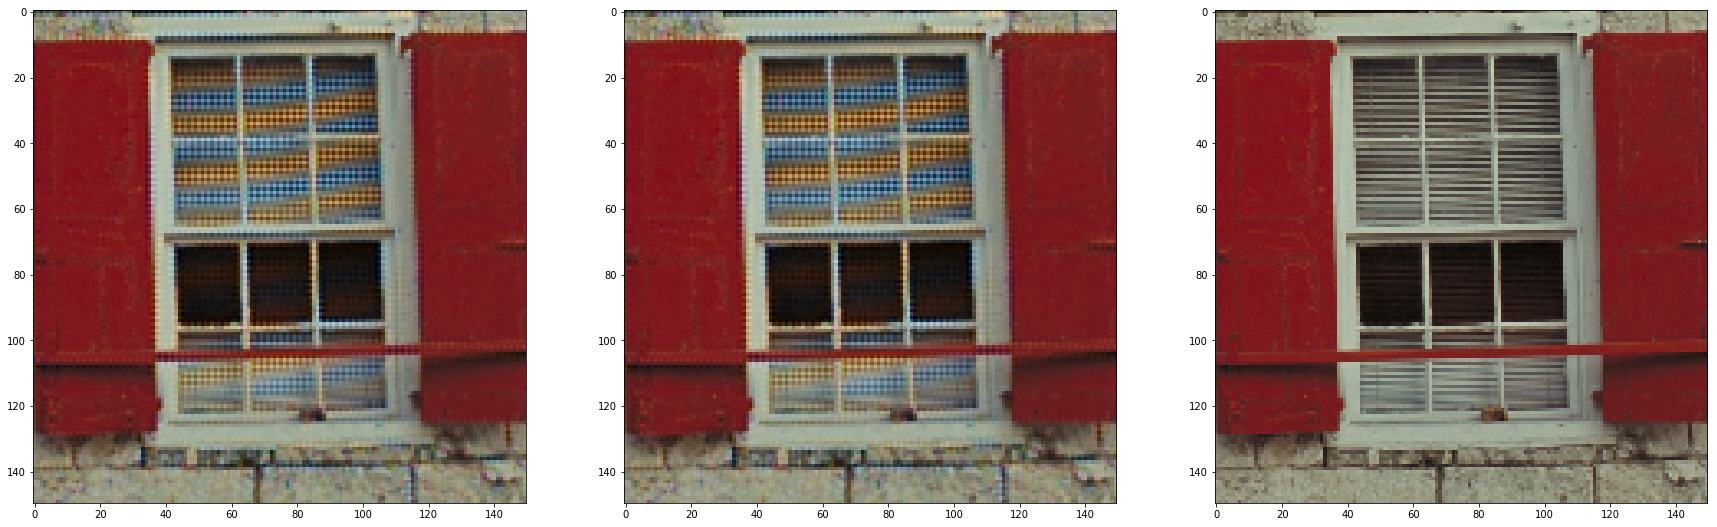

In [83]:
figure, axs = plt.subplots(1, 3, figsize=(30, 15))

axs[0].imshow(bil_col[13][250:400, 400:550, :])
axs[1].imshow(impr[13][250:400, 400:550, :])
axs[2].imshow(gt_col[13][250:400, 400:550, :])
plt.show()

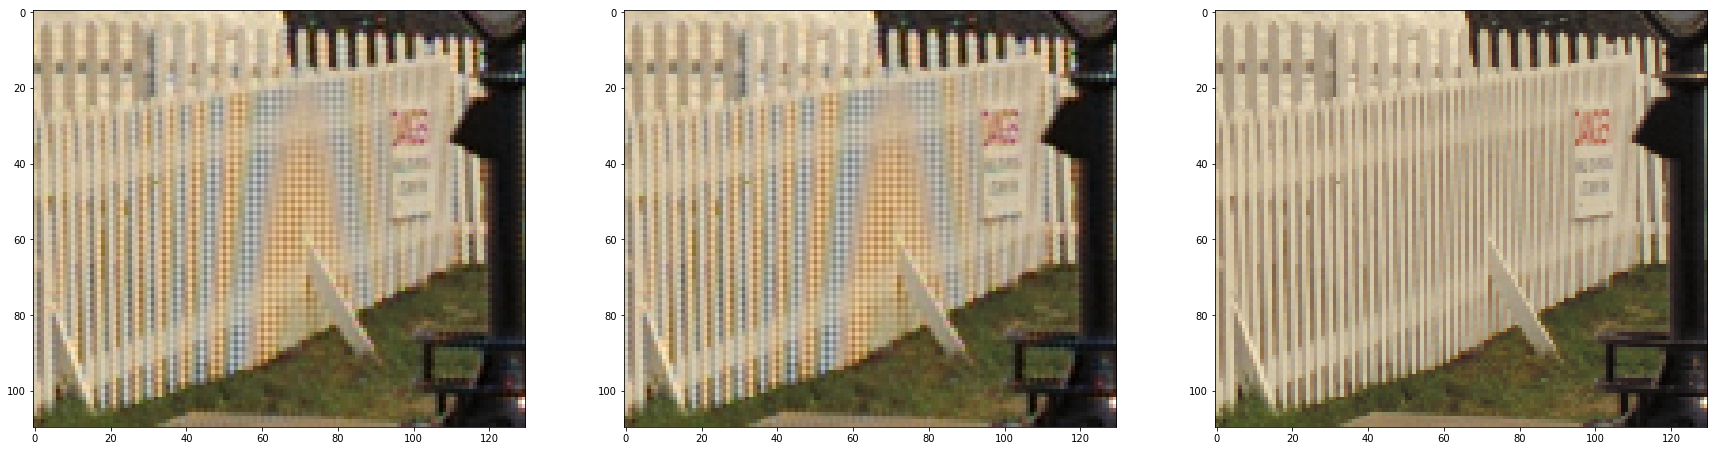

In [84]:
figure, axs = plt.subplots(1, 3, figsize=(30, 15))

axs[0].imshow(bil_col[17][430:540, 320:450, :])
axs[1].imshow(impr[17][430:540, 320:450, :])
axs[2].imshow(gt_col[17][430:540, 320:450, :])
plt.show()

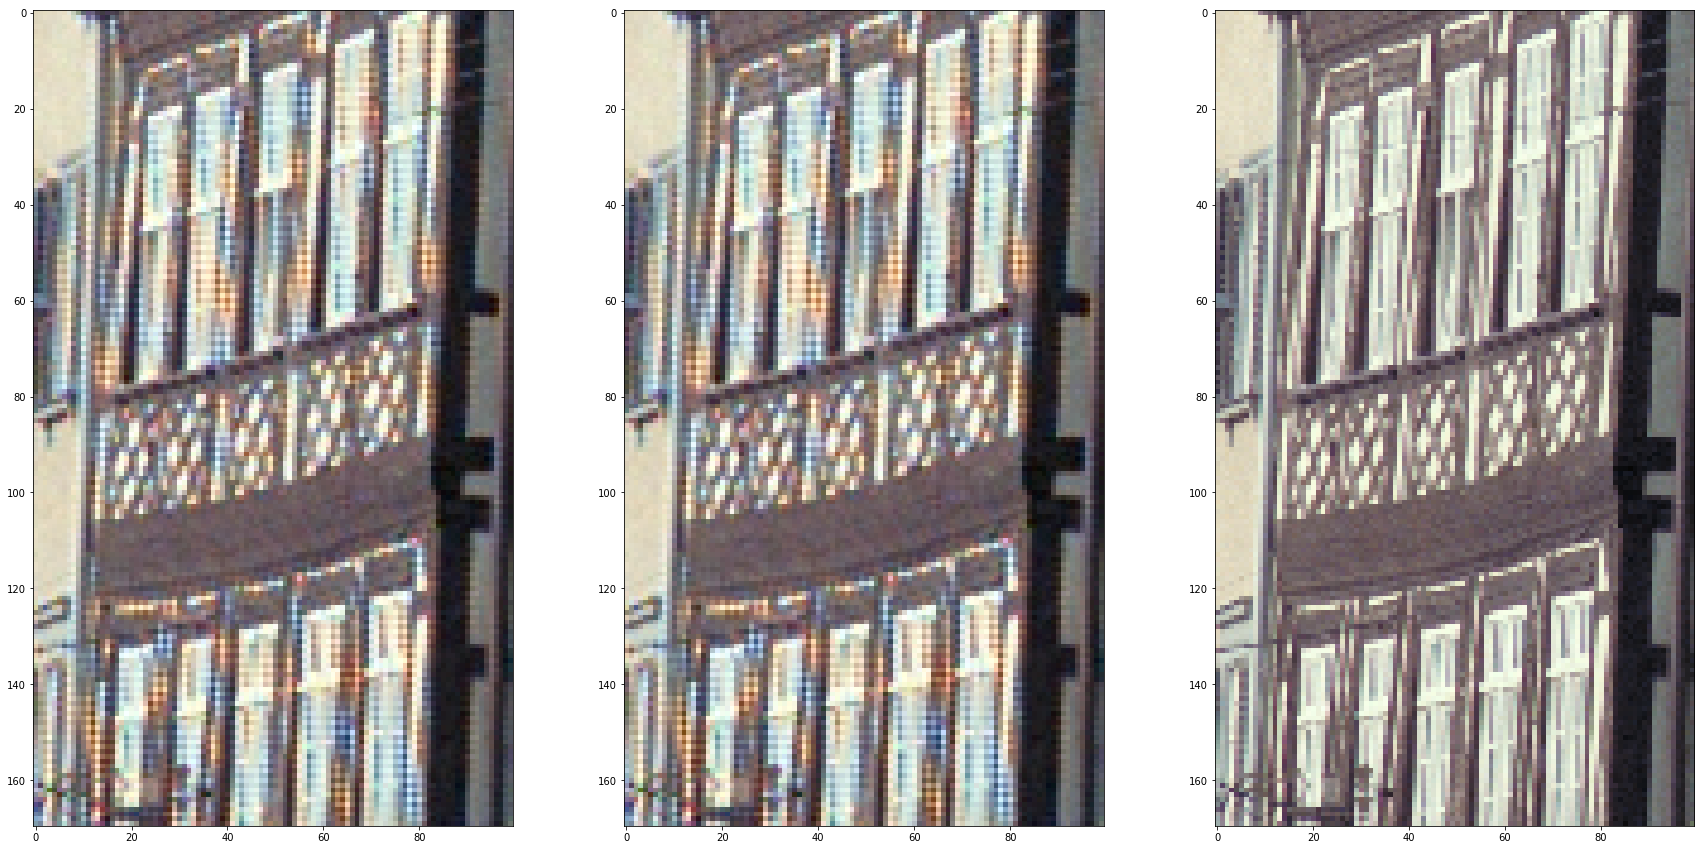

In [85]:
figure, axs = plt.subplots(1, 3, figsize=(30, 15))

axs[0].imshow(bil_col[22][270:440, 150:250, :])
axs[1].imshow(impr[22][270:440, 150:250, :])
axs[2].imshow(gt_col[22][270:440, 150:250, :])
plt.show()

Как видим разница между биленейной и улучшенной интерполяцией незаметна